# Extract cell level results

In [1]:
import os
import numpy as np
import bigfish
import bigfish.stack as stack
import bigfish.multistack as multistack
import bigfish.plot as plot
import matplotlib.pyplot as plt
from skimage import segmentation
import matplotlib.patches as mpatches
from scipy import ndimage
print("Big-FISH version: {0}".format(bigfish.__version__))

Big-FISH version: 0.6.2


In [2]:
# hard-code the paths of our input and output directories
path_input = "/data/smFISH/20251028_bartelle_smFISH_mm_microglia_newbuffers/qi2labdatastore/big_fish"
path_output = "/data/smFISH/20251028_bartelle_smFISH_mm_microglia_newbuffers/qi2labdatastore/big_fish"


In this notebook, we show examples to **extract results at the cell level**. We combine the results of the previous notebooks. As a reminder, segmentation is performed in 2D, but detection can be performed in 2D or 3D. Several steps are presented:
- Presentation of the different formats expected for the segmentation and detection results.
- Detection and filtering of the transcription sites.
- Extraction of the FoV results at the cell levels.
- Cell plots.

In [ ]:
path = os.path.join(path_input, "max_projected_tile000round000corrected_polyDT.ome.tiff")
polyDT_mip = stack.read_image(path)
# nuc_mip = stack.maximum_projection(nuc)
print("polyDT channel")
print("\r shape: {0}".format(polyDT_mip.shape))
print("\r dtype: {0}".format(polyDT_mip.dtype), "\n")

path = os.path.join(path_input, "tile000bit004.ome.tiff")
rna = stack.read_image(path)
rna_mip = stack.maximum_projection(rna)
print("smfish channel")
print("\r shape: {0}".format(rna.shape))
print("\r dtype: {0}".format(rna.dtype))


# stretch the contrast otherwise the spots will be dim and hard to see
polyDT_image_contrasted = stack.rescale(polyDT_mip, channel_to_stretch=0)

image_contrasted = stack.rescale(rna, channel_to_stretch=0)
image_contrasted = stack.maximum_projection(image_contrasted)

polyDT channel
 shape: (2048, 2048)
 dtype: uint16 

smfish channel
 shape: (63, 2048, 2048)
 dtype: uint16


## Read segmentation and detection results

Intermediate results that are saved during the analysis need to follow a specific format:
- **Segmented cells** can be saved in a tif file. It should be a 2D array with integers (np.uint8, np.uint16 or np.int64). This array is required.
- **Segmented nuclei** can be saved in a tif file. It should be a 2D array with integers (np.uint8, np.uint16 or np.int64). This array is optional. If None, transcription sites are not identified.
- **Spots coordinates** can be saved in a npy file or a csv file. It should be a 2D array with np.int64 or np.float64 dtype. This array is optional. If None, spots are not assigned to the segmented cells.
- **Clusters coordinates** can be saved in a npy file or a csv file. It should be a 2D array with np.int64 or np.float64 dtype. This array is optional. Clusters can be later defined as foci or transcription sites. If None, clusters are not identified and assigned to the segmented cells.
- **FoV images** can be saved in a png file. It should be a 2D array with np.uint8 or np.uint16 dtype. This array is optional. If None, images of the individual cells are not returned.

In [4]:
# segmented cells
path = os.path.join(path_output, "max_projected_tile000round000corrected_polyDT.ome_cp_masks.tif")
cell_label = stack.read_image(path)
print("segmented cells")
print("\r shape: {0}".format(cell_label.shape))
print("\r dtype: {0}".format(cell_label.dtype), "\n")

# # segmented nuclei
# path = os.path.join(path_output, "nuc_label.tif")
# nuc_label = stack.read_image(path)
# print("segmented nuclei")
# print("\r shape: {0}".format(nuc_label.shape))
# print("\r dtype: {0}".format(nuc_label.dtype), "\n")

# detected spots
path = os.path.join(path_output, "spots.csv")
spots = stack.read_array_from_csv(path, dtype=np.int64)
print("detected spots")
print("\r shape: {0}".format(spots.shape))
print("\r dtype: {0}".format(spots.dtype), "\n")

# detected foci
path = os.path.join(path_output, "clusters.csv")
clusters = stack.read_array_from_csv(path, dtype=np.int64)
print("detected clusters")
print("\r shape: {0}".format(clusters.shape))
print("\r dtype: {0}".format(clusters.dtype))

segmented cells
 shape: (2048, 2048)
 dtype: uint16 

detected spots
 shape: (4070, 4)
 dtype: int64 

detected clusters
 shape: (56, 5)
 dtype: int64


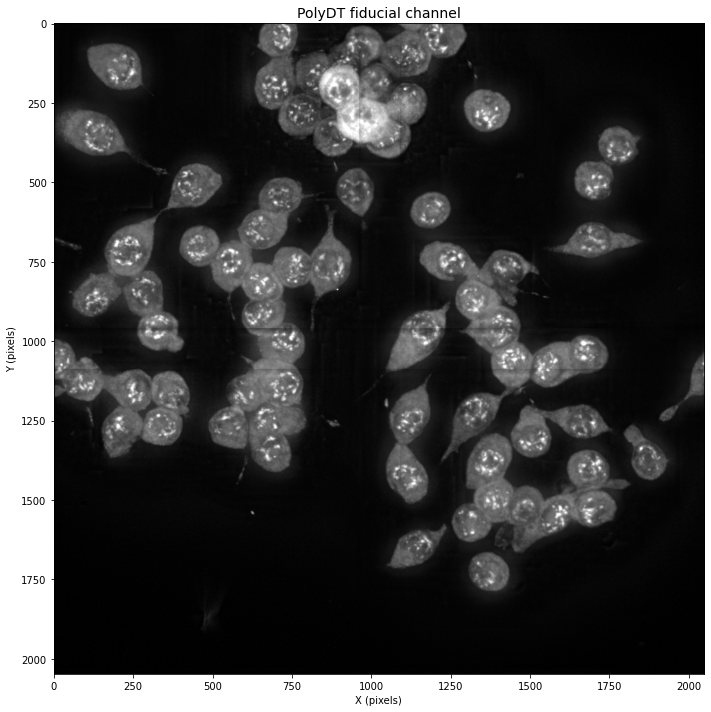

In [ ]:
# visuzalize the Cellpose segmentations on top of the polyDT channel

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Display the polyDT_mip image
ax.imshow(polyDT_image_contrasted, cmap='gray')

# Overlay the cellpose segmentation masks as outlines using contour
ax.contour(cell_label, levels=np.unique(cell_label)[1:], colors='red', linewidths=0.5, alpha=0.7)

# # Overlay the cellpose segmentation masks as outlines
# # Use find_boundaries to get the edges of the segmentation
# boundaries = segmentation.find_boundaries(cell_label, mode='inner')
# ax.imshow(boundaries, cmap='Reds', alpha=0.5)

ax.set_title('PolyDT fiducial channel with Cellpose segmentation masks', fontsize=14)
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')

plt.tight_layout()
plt.show()

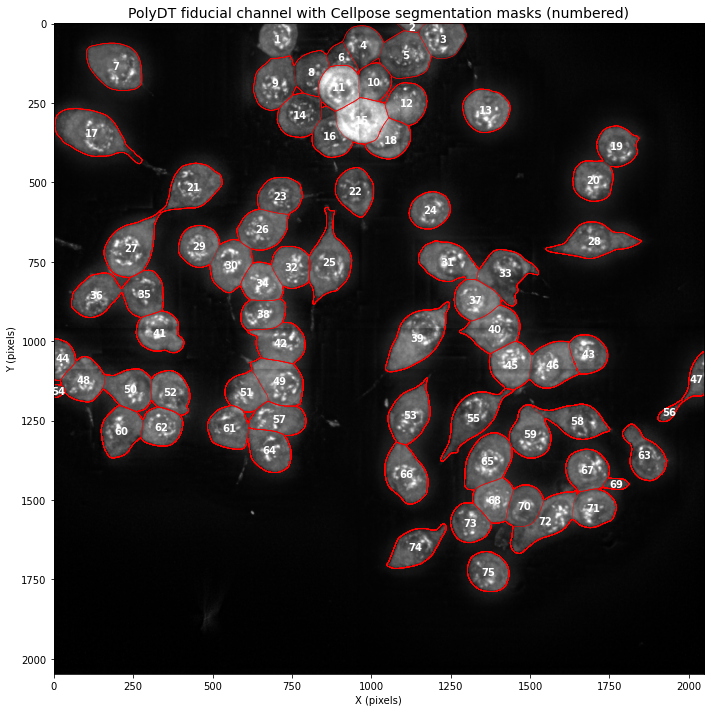

In [17]:
# create the figure with cells numbered

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Display the polyDT_mip image
ax.imshow(polyDT_image_contrasted, cmap='gray')

# Overlay the cellpose segmentation masks as outlines using contour
ax.contour(cell_label, levels=np.unique(cell_label)[1:], colors='red', linewidths=0.5, alpha=0.7)

# # Overlay the cellpose segmentation masks as outlines
# # Use find_boundaries to get the edges of the segmentation
# boundaries = segmentation.find_boundaries(cell_label, mode='inner')
# ax.imshow(boundaries, cmap='Reds', alpha=0.5)

# Add cell numbers at the centroid of each cell
cell_ids = np.unique(cell_label)
cell_ids = cell_ids[cell_ids != 0]  # Remove background label (0)

for cell_id in cell_ids:
    # Find centroid of the cell
    cell_mask = cell_label == cell_id
    coords = np.where(cell_mask)
    centroid_y = np.mean(coords[0])
    centroid_x = np.mean(coords[1])
    
    # Add text label at centroid
    ax.text(centroid_x, centroid_y, str(int(cell_id)), 
            color='white', fontsize=10, fontweight='bold',
            ha='center', va='center',
            )

ax.set_title('PolyDT fiducial channel with Cellpose segmentation masks (numbered)', fontsize=14)
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')

plt.tight_layout()
plt.show()

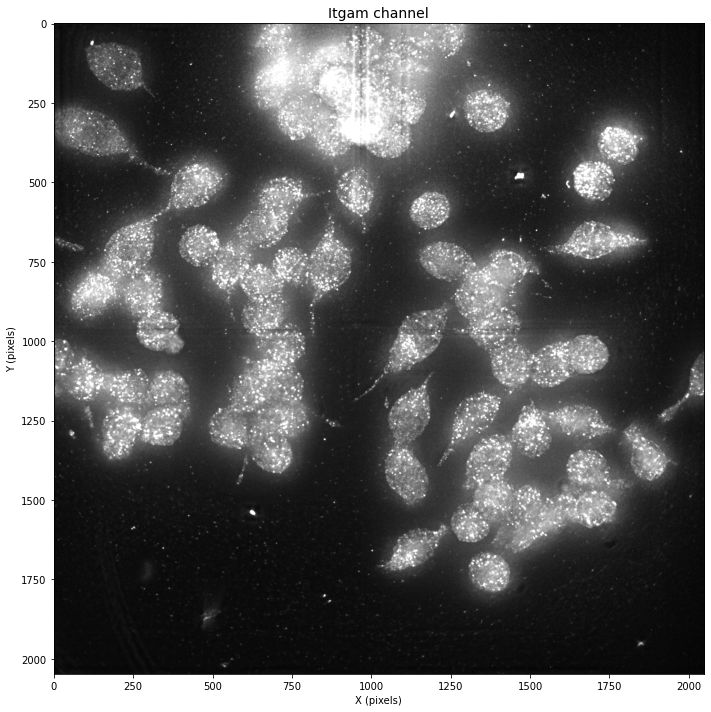

In [24]:
# visuzalize the Cellpose segmentations on top of the Itgam channel

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Display the Itgam channel image
ax.imshow(image_contrasted, cmap='gray')

# # Overlay the cellpose segmentation masks as outlines using contour
# ax.contour(cell_label, levels=np.unique(cell_label)[1:], colors='red', linewidths=0.5, alpha=0.7)

# # Overlay the cellpose segmentation masks as outlines
# # Use find_boundaries to get the edges of the segmentation
# boundaries = segmentation.find_boundaries(cell_label, mode='inner')
# ax.imshow(boundaries, cmap='Reds', alpha=0.5)

ax.set_title('Itgam channel', fontsize=14)
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')

plt.tight_layout()
plt.show()

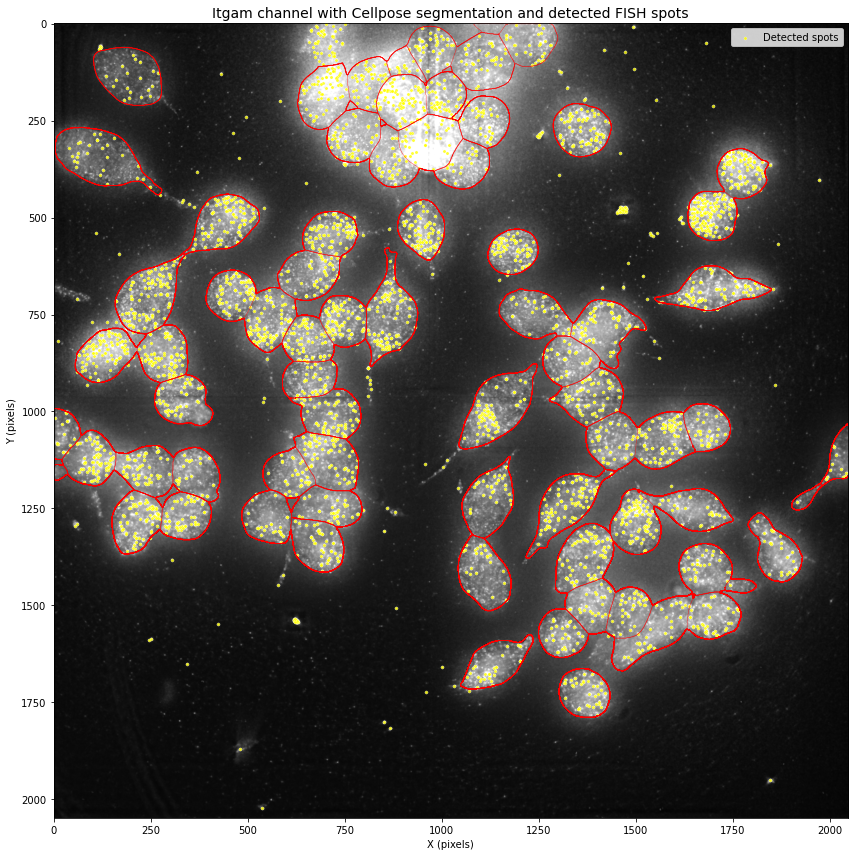

In [22]:
# visualize the RNA channel with Cellpose segmentations and detected FISH spots

# Create figure and axes
fig, ax = plt.subplots(figsize=(14, 12))

# Display the contrast-enhanced Itgam channel image in grayscale
ax.imshow(image_contrasted, cmap='gray')

# Overlay the cellpose segmentation masks as outlines using contour
ax.contour(cell_label, levels=np.unique(cell_label)[1:], colors='red', linewidths=0.5, alpha=0.7)

# Overlay detected FISH spots
# spots has shape (n_spots, 4) with format (z, y, x, intensity)
spot_z = spots[:, 0]
spot_y = spots[:, 1]
spot_x = spots[:, 2]

# Plot detected spots as yellow circles (smaller size)
ax.scatter(spot_x, spot_y, c='yellow', s=10, marker='o', 
           edgecolors='white', linewidth=0.3, alpha=0.8, label='Detected spots')

ax.set_title('Itgam channel with Cellpose segmentation and detected FISH spots', fontsize=14)
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

## Transcription sites

We can discriminate **foci** from **transcription sites** with the function `bigfish.multistack.remove_transcription_site`. A transcription site is a cluster detected inside the nucleus, when the foci define the others clusters detected in the cell.

In [ ]:
# spots_no_ts, foci, ts = multistack.remove_transcription_site(spots, clusters, nuc_label, ndim=3)
# print("detected spots (without transcription sites)")
# print("\r shape: {0}".format(spots_no_ts.shape))
# print("\r dtype: {0}".format(spots_no_ts.dtype))

More generally, we can **identify objects in specific cellular compartments** with the function `bigfish.multistack.identify_objects_in_region`.

In [ ]:
# spots_in, spots_out = multistack.identify_objects_in_region(nuc_label, spots, ndim=3)
# print("detected spots (inside nuclei)")
# print("\r shape: {0}".format(spots_in.shape))
# print("\r dtype: {0}".format(spots_in.dtype), "\n")
# print("detected spots (outside nuclei)")
# print("\r shape: {0}".format(spots_out.shape))
# print("\r dtype: {0}".format(spots_out.dtype))

## Extract cells information

**Cell extraction** is based on cell segmentation. FoV results (segmentation and detection) are assigned to each segmented cells. The function `bigfish.multistack.extract_cell` returns a list of dictionaries, one per cell. Each dictionary can include several keys, for example:
- *cell_mask* for the cell mask in 2D.
- *cell_coord* for the cell boundary coordinates in 2D. (optional)
- *nuc_mask* for the nucleus mask in 2D. (optional)
- *nuc_coord* for the nucleus boundary coordinates in 2D. (optional)
- *rna_coord* for the detected RNAs coordinates in 3D or 2D. (optional)
- *others_coord* for additional coordinates in 3D or 2D. (optional)
- *image* for an image of the cell in 2D. (optional)
- *others_image* for additional images in 2D. (optional)

In [ ]:
fov_results = multistack.extract_cell(
    cell_label=cell_label, 
    ndim=3, 
    # nuc_label=nuc_label, 
    # rna_coord=spots_no_ts, 
    # others_coord={"foci": foci, "transcription_site": ts},
    image=image_contrasted,
    # others_image={"dapi": nuc_mip, "smfish": rna_mip}
)
print("number of cells identified: {0}".format(len(fov_results)))

To visualize the results of your extraction you can plot each cell with its coordinate representation (`bigfish.plot.plot_cell`) or summarize all the results in a dataframe (`bigfish.multistack.summarize_extraction_results`).

In [ ]:
for i, cell_results in enumerate(fov_results):
    print("cell {0}".format(i))
    
    # get cell results
    cell_mask = cell_results["cell_mask"]
    cell_coord = cell_results["cell_coord"]
    # nuc_mask = cell_results["nuc_mask"]
    # nuc_coord = cell_results["nuc_coord"]
    # rna_coord = cell_results["rna_coord"]
    # foci_coord = cell_results["foci"]
    # ts_coord = cell_results["transcription_site"]
    image_contrasted = cell_results["image"]
    # print("\r number of rna {0}".format(len(rna_coord)))
    # print("\r number of foci {0}".format(len(foci_coord)))
    # print("\r number of transcription sites {0}".format(len(ts_coord)))
    
    # plot cell
    plot.plot_cell(
        ndim=3, cell_coord=cell_coord, 
        # nuc_coord=nuc_coord, 
        # rna_coord=rna_coord, 
        # foci_coord=foci_coord, 
        # other_coord=ts_coord, 
        image=image_contrasted, cell_mask=cell_mask, 
        # nuc_mask=nuc_mask, 
        title="Cell {0}".format(i))

In [ ]:
df = multistack.summarize_extraction_results(fov_results, ndim=3)
print("shape: {0}".format(df.shape))
# df.head()
import pandas as pd
pd.set_option('display.max_rows', None)
print(df)

## Save cell-level results

To save the results obtained at the cell-level, two methods are possible:
- Save each element in a separate file (masks in a tif file, coordinates arrays in a npy or csv file and images in png file).
- Save everything in a **single npz file** (format specific to numpy), assigning each element with a keyword. Functions `bigfish.stack.save_cell_extracted` and `bigfish.stack.read_cell_extracted` can be used for this purpose.

In [ ]:
for i, cell_results in enumerate(fov_results):
    # save results
    path = os.path.join(path_output, "results_cell_{0}.npz".format(i))
    stack.save_cell_extracted(cell_results, path)

In [ ]:
# read results for the first cell of the FoV
path = os.path.join(path_output, "results_cell_0.npz")
cell_results = stack.read_cell_extracted(path, verbose=True)
print(cell_results["rna_coord"])